<pre>含并行连结的网络（GoogLeNet）
在2014年的ImageNet图像识别挑战赛中，一个名叫GoogLeNet (Szegedy et al., 2015)的网络架构大放异彩。  
GoogLeNet吸收了NiN中串联网络的思想，并在此基础上做了改进。  
这篇论文的一个重点是解决了什么样大小的卷积核最合适的问题。   
毕竟，以前流行的网络使用小到1*1，大到11*11的卷积核。  
本文的一个观点是，有时使用不同大小的卷积核组合是有利的。   
本节将介绍一个稍微简化的GoogLeNet版本：我们省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的。

Inception块

在GoogLeNet中，基本的卷积块被称为Inception块（Inception block）。  
这很可能得名于电影《盗梦空间》（Inception），因为电影中的一句话“我们需要走得更深”（“We need to go deeper”）。

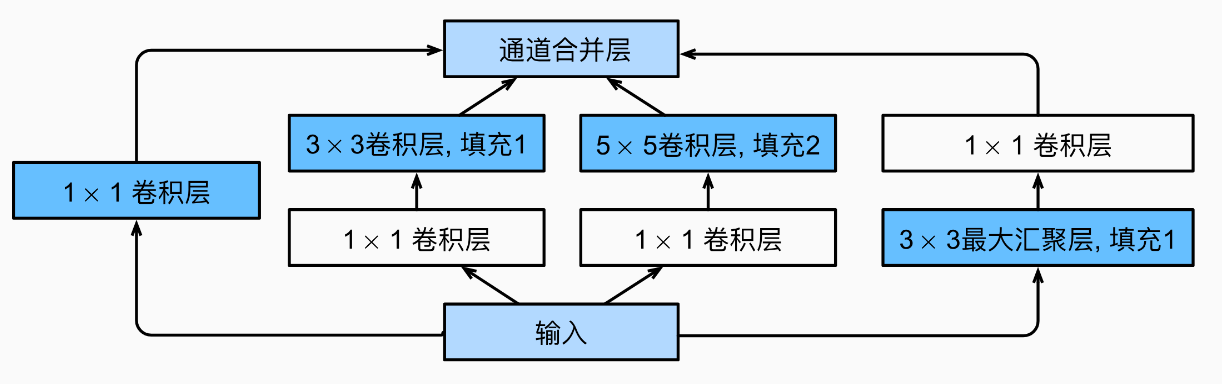

<pre>Inception块由四条并行路径组成。   
前三条路径使用窗口大小为1*1、3*3和5*5的卷积层，从不同空间大小中提取信息。   
中间的两条路径在输入上执行1*1卷积，以减少通道数，从而降低模型的复杂性。   
第四条路径使用3*3最大汇聚层，然后使用1*1卷积层来改变通道数。   
这四条路径都使用合适的填充来使输入与输出的高和宽一致，最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。  
在Inception块中，通常调整的超参数是每层输出通道数。

In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)#(3,1组合size不变)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)


那么为什么GoogLeNet这个网络如此有效呢？   
首先我们考虑一下滤波器（filter）的组合，它们可以用各种滤波器尺寸探索图像，这意味着不同大小的滤波器可以有效地识别不同范围的图像细节。   
同时，我们可以为不同的滤波器分配不同数量的参数。

GoogLeNet模型

如图所示，GoogLeNet一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。  
Inception块之间的最大汇聚层可降低维度。   
第一个模块类似于AlexNet和LeNet，Inception块的组合从VGG继承，全局平均汇聚层避免了在最后使用全连接层。  
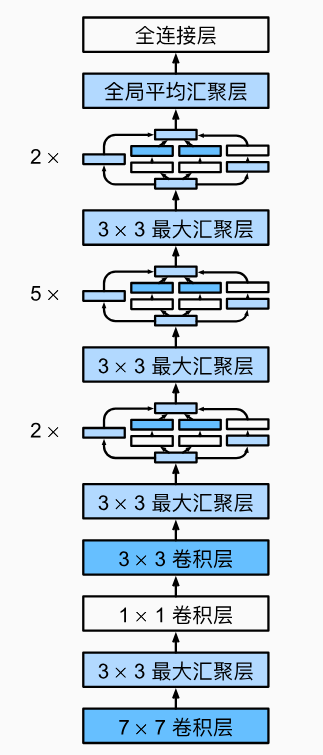

逐一实现GoogLeNet的每个模块。第一个模块使用64个通道、7*7卷积层

In [18]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   # (224-(7-1)+2*3+2-1)/2=112
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
                   # (112-(3-1)+2*1+2-1)/2=56


第二个模块使用两个卷积层：第一个卷积层是64个通道、1*1卷积层；第二个卷积层使用将通道数量增加三倍的3\*3卷积层。 这对应于Inception块中的第二条路径。

In [19]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   #(56-(3-1)+2*1+1-1)/1=56
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
                   #(56-(3-1)+2*1+2-1)/2=28


第三个模块串联两个完整的Inception块。  
第一个Inception块的输出通道数为64+128+32+32=256，四个路径之间的输出通道数量比为64:128:32:32=2:4:1:1。  
第二个和第三个路径首先将输入通道的数量分别减少96/192=1/2到和16/192=1/12，然后连接第二个卷积层。   
第二个Inception块的输出通道数增加到128+192+96+64=480，四个路径之间的输出通道数量比为128:192:96:64=4:6:3:2。    
第二条和第三条路径首先将输入通道的数量分别减少到128/256=1/2和32/256=1/8。

In [20]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#14


第四模块更加复杂， 它串联了5个Inception块，其输出通道数分别是:  
192+208+4864=512、160+224+64+64=512、128+256+64+64=512、112+288+64+64=528和256+320+128+128=832。   
这些路径的通道数分配和第三模块中的类似，首先是含3\*3卷积层的第二条路径输出最多通道，  
其次是仅含1\*1卷积层的第一条路径，之后是含5\*5卷积层的第三条路径和含最大汇聚层的第四条路径。   
其中第二、第三条路径都会先按比例减小通道数。   
这些比例在各个Inception块中都略有不同。

In [21]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#7

第五模块包含输出通道数为256+320+128+128=832和384+384+128+128=1024的两个Inception块。   
其中每条路径通道数的分配思路和第三、第四模块中的一致，只是在具体数值上有所不同。   
需要注意的是，第五模块的后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1。   
最后我们将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层。

In [22]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),#1024*1
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))


GoogLeNet模型的计算复杂，而且不如VGG那样便于修改通道数。   
为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96，这简化了计算。  
下面演示各个模块输出的形状变化。

In [23]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


训练模型

和以前一样，我们使用Fashion-MNIST数据集来训练我们的模型。在训练之前，我们将图片转换为96*96分辨率。

train_loss 0.425,test_loss 0.464, train acc 0.841, test acc 0.816
536.3 examples/sec on cuda:0


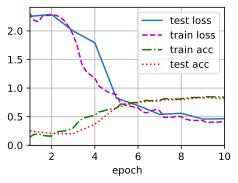

In [24]:
lr, num_epochs, batch_size = 0.1, 10, 320
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
